# Lab | Making predictions with logistic regression

In order to optimize our inventory, we would like to predict if a film will have more monthly rentals in July than in June. Create a model to predict it.

1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.

In [307]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

 ········


In [526]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''SELECT cat.name as genre, f.length film_length, f.rating, f.release_year, i.store_id as store
FROM sakila.rental r
JOIN sakila.inventory i
ON r.inventory_id = i.inventory_id
JOIN sakila.film f
ON i.film_id = f.film_id
JOIN sakila.film_category fc
ON f.film_id = fc.film_id
JOIN sakila.category cat
ON fc.category_id = cat.category_id
;'''

data = pd.read_sql_query(query, engine)
data.head()
data.shape

(16045, 5)

2. Create a query to get the total amount of rentals in June for each film. 

In [524]:
query = '''SELECT i.film_id, COUNT(r.inventory_id)
FROM sakila.rental r
JOIN sakila.inventory i
ON r.inventory_id = i.inventory_id
WHERE LEFT(r.rental_date, 7) = '2005-06' 
GROUP BY  i.film_id;  ''' 

june = pd.read_sql_query(query, engine)
june.head()

,film_id,COUNT(r.inventory_id)
0,1,3
1,3,1
2,4,2
3,5,2
4,6,3


3. Do the same with July. 

In [522]:
query= '''SELECT i.film_id, COUNT(r.inventory_id)
FROM sakila.rental r
JOIN sakila.inventory i
ON r.inventory_id = i.inventory_id
WHERE LEFT(r.rental_date, 7) = '2005-07' 
GROUP BY  i.film_id
'''

july = pd.read_sql_query(query, engine)
july.head()

,film_id,COUNT(r.inventory_id)
0,1,9
1,2,2
2,3,4
3,4,12
4,5,5


4. Create a new column containing (Yes/No) for each film whether or not the number of monthly rentals in **July was bigger than in June**. Your objective will be to predict this new column.

In [525]:
import numpy as np

#Drop film_id from smaller df to avoid NaNs

june.drop('film_id', axis = 1, inplace = True)
df = pd.concat(([june, july]), axis = 1).reset_index()


#After reseting the index I drop the Column INDEX and rename the other column names

df.drop(df.columns[[0]], axis = 1, inplace=True)
df.columns = ['rent_june', 'film_id', 'rent_july']

df.head()

,rent_june,film_id,rent_july
0,3.0,1,9
1,1.0,2,2
2,2.0,3,4
3,2.0,4,12
4,3.0,5,5


In [313]:
#df['film_id'].isna()


# Add new column with condition: 
    

df['YES/NO'] = ['YES'if df['rent_june'][i] < df['rent_july'][i] else 'NO' for i in range(len(df['film_id']))]
df['YES/NO'].unique()

dfy = df.copy() 
dfy.head()


,rent_june,film_id,rent_july,YES/NO
0,3.0,1,9,YES
1,1.0,2,2,YES
2,2.0,3,4,YES
3,2.0,4,12,YES
4,3.0,5,5,YES


6.Read the data into a Pandas dataframe.

In [314]:
## Imported another SET after realizing that the first query was for all films ever rented. 
## I contraint the query to June and July in order to be able to combine the YES/NO column


query = '''
SELECT cat.name as genre, f.length film_length, f.film_id, r.inventory_id, f.rating, f.release_year
FROM sakila.rental r
JOIN sakila.inventory i
ON r.inventory_id = i.inventory_id
JOIN sakila.film f
ON i.film_id = f.film_id
JOIN sakila.film_category fc
ON f.film_id = fc.film_id
JOIN sakila.category cat
ON fc.category_id = cat.category_id
WHERE LEFT(r.rental_date, 7) = '2005-06' OR LEFT(r.rental_date, 7) = '2005-07' ;
'''

dfx = pd.read_sql_query(query, engine)


display(dfx.head())
display(y.head())

print(dfy.shape)
print(dfx.shape)

    





,genre,film_length,film_id,inventory_id,rating,release_year
0,Action,113,19,94,PG,2006
1,Action,113,19,94,PG,2006
2,Action,113,19,94,PG,2006
3,Action,113,19,95,PG,2006
4,Action,113,19,95,PG,2006


,YES/NO
0,YES
1,YES
2,YES
3,YES
4,YES


(958, 4)
(9020, 6)


In [338]:
# I want to lable each film that was rented in June and July with YES/NO 
# --> Compare the film_ids and add a new column corresponding to the YES/No column for that film_id

#APPROACH: Using the index to extract corresponding Y/N

i = []
for elem in (dfx['film_id']):
    i.append(dfy[dfy.film_id == elem].index.item())    
    
def yes(x):
    return y['YES/NO'][x]   
    
dfx['YES/NO'] = list(map(yes, i))   

In [ ]:
#y[y['film_id'] == 19].index.values.astype(int)[0]
#y[y.film_id == 19].index.item()
#dfx['YES/NO'].isna().sum()

In [493]:
# DROP DUPLICATED ROWS 

dfx[dfx.duplicated()] 
dfx.drop_duplicates(inplace = True)

In [494]:
# DEVIDE DATA INTO DEPENDENT AND IDEPENDENT VARIABLES


y = dfx[['YES/NO']]
X = dfx.drop(['YES/NO', 'film_id', 'inventory_id'], axis = 1)
X = pd.DataFrame(X)

### 7. Analyze extracted features and transform them. You may need to encode some categorical variables or scale numerical variables.


In [498]:
X.describe()

,film_length,release_year
count,4254.000000,4254.0
mean,115.127174,2006.0
std,40.091860,0.0
min,46.000000,2006.0
25%,81.250000,2006.0
50%,114.000000,2006.0
75%,148.000000,2006.0
max,185.000000,2006.0


In [499]:
X['genre'].describe()
X['genre'].unique()

# -> No Null Values

## -> NEXT STEP: OneHotEncoder

array(['Action', 'Animation', 'Children', 'Classics', 'Comedy',
       'Documentary', 'Drama', 'Family', 'Foreign', 'Games', 'Horror',
       'Music', 'New', 'Sci-Fi', 'Sports', 'Travel'], dtype=object)

count    4254.000000
mean      115.127174
std        40.091860
min        46.000000
25%        81.250000
50%       114.000000
75%       148.000000
max       185.000000
Name: film_length, dtype: float64

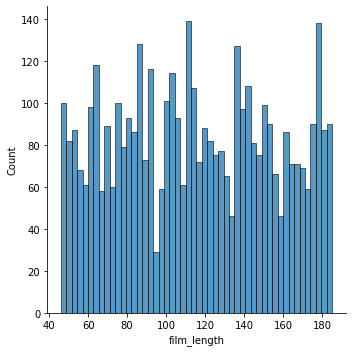

In [500]:
X['film_length'].unique()
X['film_length'].describe()
X['film_length'].value_counts()

sns.displot(X['film_length'], bins = 50)
X['film_length'].describe()


# -> NEXT STEP: Scaling 

In [501]:
X['rating'].describe()
X['rating'].unique()

# -> no Null Values

## -> NEXT STEP: OneHotEncoder

array(['PG', 'R', 'NC-17', 'G', 'PG-13'], dtype=object)

In [528]:
X['release_year'].unique()

# -> since the release year consists of only one unique value I will drop it from the independend variables. 



KeyError: 'release_year'

In [529]:
X.drop('release_year', axis = 1, inplace = True)

KeyError: "['release_year'] not found in axis"

### 8. Create a logistic regression model to predict this new column from the cleaned data.

In [503]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import seaborn as sns
%matplotlib inline

In [505]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [506]:
X_train 
y_train

X_train_cat = X_train.select_dtypes(['object'])
X_train_num = X_train[['film_length']]

X_test_cat = X_test.select_dtypes(['object'])
X_test_num = X_test[['film_length']]




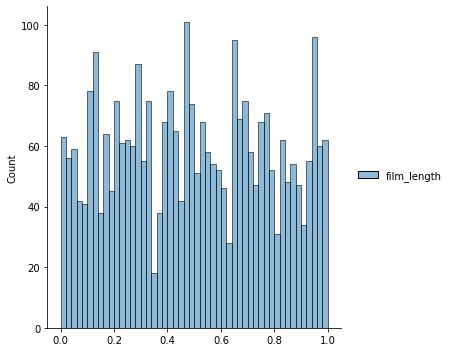

In [507]:
# SCALING X_train_num & X_test_num:

scaler = MinMaxScaler()
X_train_num_transf = scaler.fit_transform(X_train_num)
X_train_num_transf = pd.DataFrame(X_train_num_transf, columns = X_train_num.columns)
sns.displot(X_train_num_transf , bins = 50)

## ..... X_test_num

scaler = MinMaxScaler()
X_test_num_transf = scaler.fit_transform(X_test_num)
X_test_num_transf = pd.DataFrame(X_test_num_transf, columns = X_test_num.columns)


In [508]:
# ONE-HOT-ENCODER X_train_cat & X_test_cat


enc = OneHotEncoder(drop='first')    
X_train_cat_ohe = enc.fit_transform(X_train_cat).toarray()
col = enc.get_feature_names_out()
X_train_cat_ohe = pd.DataFrame(X_train_cat_ohe, columns=col)



# .... X_test_cat

enc = OneHotEncoder(drop='first')
X_test_cat_ohe = enc.fit_transform(X_test_cat).toarray()
col = enc.get_feature_names_out()
X_test_cat_ohe = pd.DataFrame(X_test_cat_ohe, columns = col)


#X_test_cat_ohe.head()
#X_train_cat_ohe.head(2) 

In [509]:
# ALTERNATIVE OPTION = DUMMY VARIABLES 

X_test_cat_dummy = pd.get_dummies(X_test_cat, drop_first = True)


# Checking if columns match the X_train_cat_ohe

display(list((zip(list(X_test_cat_dummy.columns), list(X_train_cat_ohe.columns)))))

[('genre_Animation', 'genre_Animation'),
 ('genre_Children', 'genre_Children'),
 ('genre_Classics', 'genre_Classics'),
 ('genre_Comedy', 'genre_Comedy'),
 ('genre_Documentary', 'genre_Documentary'),
 ('genre_Drama', 'genre_Drama'),
 ('genre_Family', 'genre_Family'),
 ('genre_Foreign', 'genre_Foreign'),
 ('genre_Games', 'genre_Games'),
 ('genre_Horror', 'genre_Horror'),
 ('genre_Music', 'genre_Music'),
 ('genre_New', 'genre_New'),
 ('genre_Sci-Fi', 'genre_Sci-Fi'),
 ('genre_Sports', 'genre_Sports'),
 ('genre_Travel', 'genre_Travel'),
 ('rating_NC-17', 'rating_NC-17'),
 ('rating_PG', 'rating_PG'),
 ('rating_PG-13', 'rating_PG-13'),
 ('rating_R', 'rating_R')]

In [510]:
# Concatenating the transformed X_train and the transformed X_test

X_train_transf = pd.concat([X_train_cat_ohe, X_train_num_transf], axis = 1)
X_train_transf.head(2)

# .... concatenate X_test dfs 


X_test_transf = pd.concat([X_test_cat_ohe, X_test_num_transf], axis = 1)
X_test_transf.head(2)

,genre_Animation,genre_Children,genre_Classics,genre_Comedy,genre_Documentary,genre_Drama,genre_Family,genre_Foreign,genre_Games,genre_Horror,genre_Music,genre_New,genre_Sci-Fi,genre_Sports,genre_Travel,rating_NC-17,rating_PG,rating_PG-13,rating_R,film_length
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050360
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.194245


In [511]:
#LOGISTIC REGRESSION MODEL FIT TRANSFORM


clf = LogisticRegression(random_state = 42, ).fit(X_train_transf, y_train.values.ravel()) # ERROR WARNING tellst me: DataConversionWarning: A column-vector y was passed when a 1d array w
prediction = clf.predict(X_test_transf)
y_train_pred = clf.predict(X_train_transf)




 ### 9. Evaluate the results.

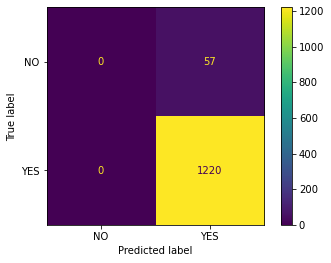

In [512]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, cohen_kappa_score, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, prediction)
cm

disp = ConfusionMatrixDisplay(cm,display_labels=clf.classes_);
disp.plot()


In [513]:
# MODEL METRICS 

print('Accuracy for train: {:.3f}'.format(accuracy_score(y_train, y_train_pred)))
print('Accuracy for test: {:.3f}'.format(accuracy_score(y_test, prediction)),'\n')

print('Precision for train YES: {:.3f}'.format(precision_score(y_train, y_train_pred, pos_label="YES")))
print('Precision for test YES: {:.3f}'.format(precision_score(y_test, prediction, pos_label="YES")),'\n')

print('Recall for train YES: {:.3f}'.format(recall_score(y_train, y_train_pred, pos_label="YES")))
print('Recall for test YES: {:.3f}'.format(recall_score(y_test, prediction, pos_label="YES")),'\n')

print('F1 for train YES: {:.3f}'.format(f1_score(y_train, y_train_pred, pos_label="YES")))
print('F1 for test YES: {:.3f}'.format(f1_score(y_test, prediction, pos_label="YES")),'\n')


Accuracy for train: 0.952
Accuracy for test: 0.955 

Precision for train YES: 0.952
Precision for test YES: 0.955 

Recall for train YES: 1.000
Recall for test YES: 1.000 

F1 for train YES: 0.975
F1 for test YES: 0.977 



In [516]:
# OR Simply: CLASSIFICATION REPORT for y_test

print(classification_report(y_test, prediction, target_names=['YES', 'NO']))


              precision    recall  f1-score   support

         YES       0.00      0.00      0.00        57
          NO       0.96      1.00      0.98      1220

    accuracy                           0.96      1277
   macro avg       0.48      0.50      0.49      1277
weighted avg       0.91      0.96      0.93      1277



/Users/steib/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/steib/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/steib/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [521]:
# COHEN KAPPA SCORE

cohen_kappa_score(y_train, y_train_pred)


0.0

In [518]:
y_train.value_counts() 

YES/NO
YES       2833
NO         144
dtype: int64